## Solar Panel Fault Identification 
### Task Model
Applied Machine Learning Project <br>

Solar Panel Fault Detection using CNN

**Task description and objectives**
- The aim of this project is to create a Machine Learning Model that accurately predicts and shows what type of defect a solar panel has, based on pictures of it.
- It will be a supervised learning model. 
- Supervised: Predict type or presence of defect (classification) based on sensor/thermal/image data.

In [47]:
# Local changes needed for better visualisation of outputs 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # hides INFO and WARNING logs|

from IPython.display import HTML

HTML('''
<style>
/* for JupyterLab: limit each output pane to 400px tall and add a scrollbar */
.jp-OutputArea-child {
  max-height: 400px;
  overflow-y: auto;
}

/* for classic Jupyter: same idea */
.output_scroll {
  max-height: 400px;
  overflow-y: auto;
}
</style>
''')

In [49]:
# Libraries used throughout this script
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import opendatasets as od
import os
from tensorflow.keras import layers, models, optimizers, losses, metrics
import pathlib
from sklearn.model_selection import train_test_split

In [50]:
# GPU configuration (run in a notebook cell)
print("Built with CUDA:", tf.test.is_built_with_cuda())

build_info = tf.sysconfig.get_build_info()
print("CUDA version (build):", build_info.get("cuda_version"))
print("cuDNN version (build):", build_info.get("cudnn_version"))

gpus = tf.config.list_physical_devices("GPU")
print("GPUs visible to TF:", gpus)

Built with CUDA: True
CUDA version (build): 12.5.1
cuDNN version (build): 9
GPUs visible to TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [51]:
od.download('https://www.kaggle.com/datasets/pythonafroz/solar-panel-images') # use force=True for forcing the download
data_dir = './solar-panel-images/Faulty_solar_panel'

Skipping, found downloaded files in "./solar-panel-images" (use force=True to force download)


In [66]:
# 1. List all image paths + labels
data_root = pathlib.Path(data_dir)
all_paths  = list(data_root.glob('*/*.jpg'))
all_labels = [p.parent.name for p in all_paths]

# 2. Train+Val vs. Test (e.g. 80/20)
paths_trainval, paths_test, labels_trainval, labels_test = train_test_split(
    all_paths, all_labels,
    test_size=0.20,
    stratify=all_labels,
    random_state=123
)

# 3. Train vs. Val within the 80%
paths_train, paths_val, labels_train, labels_val = train_test_split(
    paths_trainval, labels_trainval,
    test_size=0.20,  # 20% of 80% = 16% overall
    stratify=labels_trainval,
    random_state=123
)

# 4. Utility to build a tf.data.Dataset from (paths, labels)
def make_ds(paths, labels):
    # map filenames → (image_tensor, label_int)
    path_ds  = tf.data.Dataset.from_tensor_slices([str(p) for p in paths])
    label_to_index = {name:i for i,name in enumerate(class_names)}
    label_ds = tf.data.Dataset.from_tensor_slices([label_to_index[l] for l in labels])
    ds = tf.data.Dataset.zip((path_ds, label_ds))
    def load_and_preprocess(path, label):
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img, channels=3)
        img = tf.image.resize(img, img_size)
        return img, label
    return ds.map(load_and_preprocess, num_parallel_calls=AUTOTUNE) \
             .batch(batch_size) \
             .prefetch(AUTOTUNE)

train_ds = make_ds(paths_train, labels_train)
val_ds   = make_ds(paths_val,   labels_val)
test_ds  = make_ds(paths_test,  labels_test)

In [53]:
# Model definition
# ----------------
# Build a simple CNN using Keras Sequential API. Adjust the number of filters,
# kernel sizes, and dense units as needed for your solar-panel defect task.
num_classes = len(class_names)

model_LeNet = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),    # input layer
    layers.Conv2D(8, kernel_size=5, activation='relu'),  # conv block 1
    layers.MaxPooling2D(pool_size=2),
    layers.Conv2D(16, kernel_size=5, activation='relu'), # conv block 2
    layers.MaxPooling2D(pool_size=2),
    layers.GlobalAveragePooling2D(),                     # global pooling
    layers.Dense(128, activation='relu'),                # fully connected
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes)                            # logits output
])

model_LeNet.summary()  # prints model architecture and parameter counts|

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)               │ (None, 240, 240, 8)    │           608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 120, 120, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 116, 116, 16)   │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 58, 58, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 16)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │         2,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,646 (57.21 KB)

 Trainable params: 14,646 (57.21 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
# Model definition
# ----------------
# Build a simple CNN using Keras Sequential API. Adjust the number of filters,
# kernel sizes, and dense units as needed for your solar-panel defect task.
num_classes = len(class_names)

model = models.Sequential([
    layers.Input(shape=(img_size[0], img_size[1], 3)),    # input layer
    layers.Conv2D(64, kernel_size=11, activation='relu'),  # conv block 1
    layers.MaxPooling2D(pool_size=3),
    layers.Conv2D(128, kernel_size=5, activation='relu'),   # conv block 2
    layers.MaxPooling2D(pool_size=3),
    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.Conv2D(256, kernel_size=3, activation='relu'),
    layers.MaxPooling2D(pool_size=3),                     # global pooling
    layers.Flatten(),
    layers.Dense(512, activation='relu'),                # fully connected
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')      # logits output
])

model.summary()  # prints model architecture and parameter counts|

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 234, 234, 64)   │        23,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 78, 78, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 74, 74, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 20, 20, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,688,390 (25.51 MB)

 Trainable params: 6,688,390 (25.51 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Compile & train
# ----------------
# Configure the training process: optimizer, loss function, and metrics.
# Then fit the model on `train_ds`, validating on `val_ds`.
epochs = 100

model.compile(
    optimizer=optimizers.Adam(),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=64,
    epochs=epochs
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 16s 451ms/step - loss: 39.7078 - sparse_categorical_accuracy: 0.1717 - val_loss: 1.7585 - val_sparse_categorical_accuracy: 0.2344
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 1.7623 - sparse_categorical_accuracy: 0.2182 - val_loss: 1.7424 - val_sparse_categorical_accuracy: 0.2109
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - loss: 1.7398 - sparse_categorical_accuracy: 0.2338 - val_loss: 1.7288 - val_sparse_categorical_accuracy: 0.2344
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 1.7179 - sparse_categorical_accuracy: 0.2521 - val_loss: 1.7326 - val_sparse_categorical_accuracy: 0.2266
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step - loss: 1.7263 - sparse_categorical_accuracy: 0.2419 - val_loss: 1.7670 - val_sparse_categorical_accuracy: 0.2266
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - loss: 1.7723 - sparse_categorical_accuracy: 0.2293 - val_loss: 1.7565 - val_sparse_categorical_accuracy: 0.2

In [62]:
# Final evaluation on test set
# --------------------------------------------
# Compute loss & accuracy on the held-out test set
# (this data was never used during training or validation)
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test         → Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 1.7179 - sparse_categorical_accuracy: 0.2102
Test         → Loss: 1.7179, Accuracy: 0.2375


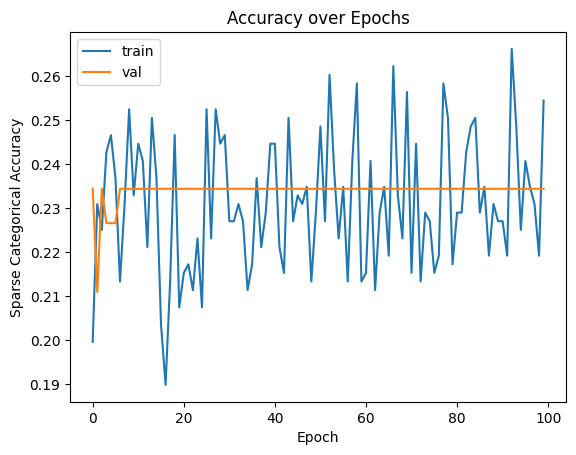

In [63]:
# Plot training & validation accuracy
# ------------------------------------
# Visualize how accuracy evolves over epochs to spot overfitting/underfitting.
plt.figure()
plt.plot(history.history['sparse_categorical_accuracy'], label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='val')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Sparse Categorical Accuracy')
plt.legend()
plt.show()

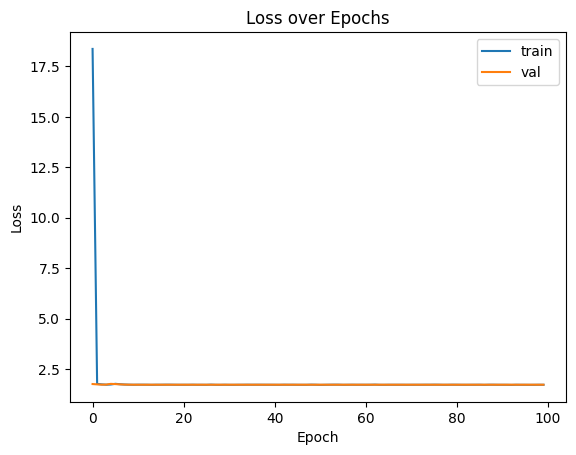

In [64]:
# Plot training & validation loss
# --------------------------------
# Show loss curves for train vs. validation to assess convergence.
plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


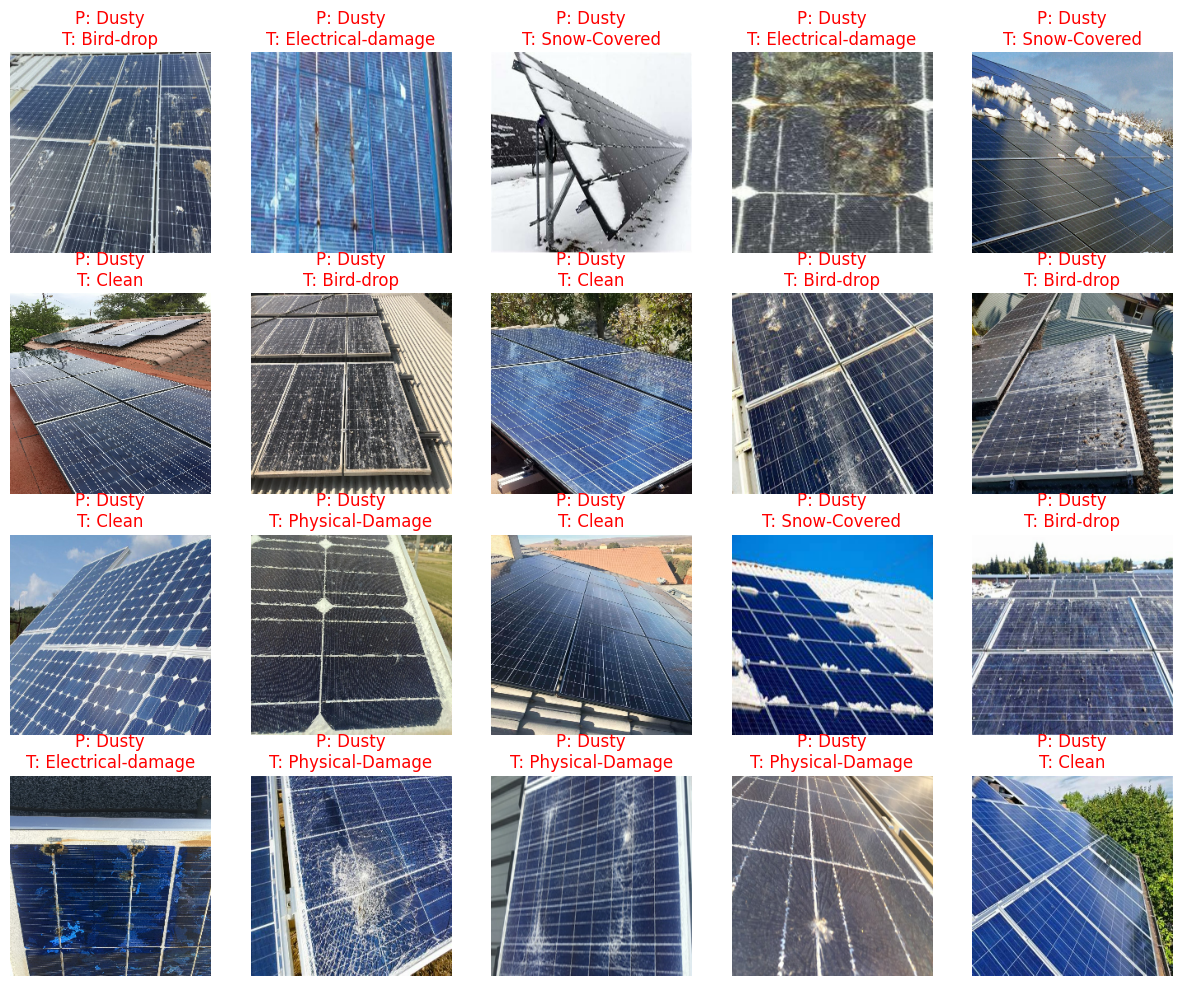

In [65]:
# Visualize sample predictions
# ----------------------------
# Take one batch from val_ds, run predictions, and display a 4×5 grid of images
# with predicted vs. true labels colored green (correct) or red (incorrect).
plt.figure(figsize=(15, 12))
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    for i in range(min(20, images.shape[0])):
        ax = plt.subplot(4, 5, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        color = 'green' if pred_labels[i] == labels[i] else 'red'
        plt.title(f"P: {class_names[pred_labels[i]]}\nT: {class_names[labels[i]]}", color=color)
        plt.axis('off')
plt.show()